# Compositional analysis of the COPD-IAV scRNA dataset using milo using MILO 
and the single cell best practices tutorial https://www.sc-best-practices.org/conditions/compositional.html#without-labeled-clusters:
- Developed by: Christian Eger
- Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg
- Created on: 231207
- Last modified: 240805<br>
6 Patients with and 6 without chronic obstructive pulmonary disease (COPD).
Epithelial cells extracted with a lung wash and exposed to IAV (Control and IAV n=3 for both COPD and healthy patients)
--> scRNA-seq and cell types annotated

## Troubleshooting

In case of error during installation of 'edgeR' into the R environment (on apple silicon): "C17 standard requested but CC17 is not defined<br>
R CMD config CC17 <br>
#if it returns nothing create a config file Makevars in /Users/username/.R/Makevars<br>
mkdir /Users/username/.R<br>
cd /Users/username/.R<br>
touch Makevars<br>
vim Makevars <br>
#insert: CC17 = clang -arch arm64 -std=gnu17<br>

## Import statements and environment prep

In [100]:
import scanpy as sc
import pandas as pd
import pertpy as pt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import scvi
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from pathlib import Path

In [2]:
rpy2.robjects.numpy2ri.activate()


## Data preparation

### Data loading

In [115]:
data_dir = Path.cwd() / '..' / '..' / '.data' 
adata_dir = data_dir / 'Marburg_cell_states_locked_ctl240709.raw.h5ad'

In [116]:
adata = sc.read_h5ad(adata_dir)
adata

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'viral_counts', 'infected_status', 'seed_labels', 'batch-scANVI'
    var: 'mt', 'ribo'
    uns: 'cell_compartment_colors', 'cell_states_colors', 'disease_colors', 'group_colors', 'infection_colors'
    obsm: 'X_scANVI', 'X_umap'

In [4]:
milo = pt.tl.Milo()
mdata = milo.load(adata)
mdata

MuData object with n_obs × n_vars = 97573 × 27208
  2 modalities
    rna:	97573 x 27208
      obs:	'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'viral_counts', 'infected_status', 'seed_labels', 'batch-scANVI'
      var:	'mt', 'ribo'
      uns:	'cell_compartment_colors', 'cell_states_colors', 'disease_colors', 'group_colors', 'infection_colors'
      obsm:	'X_scANVI', 'X_umap'
    milo:	0 x 0

### UMAP plotting among conditions

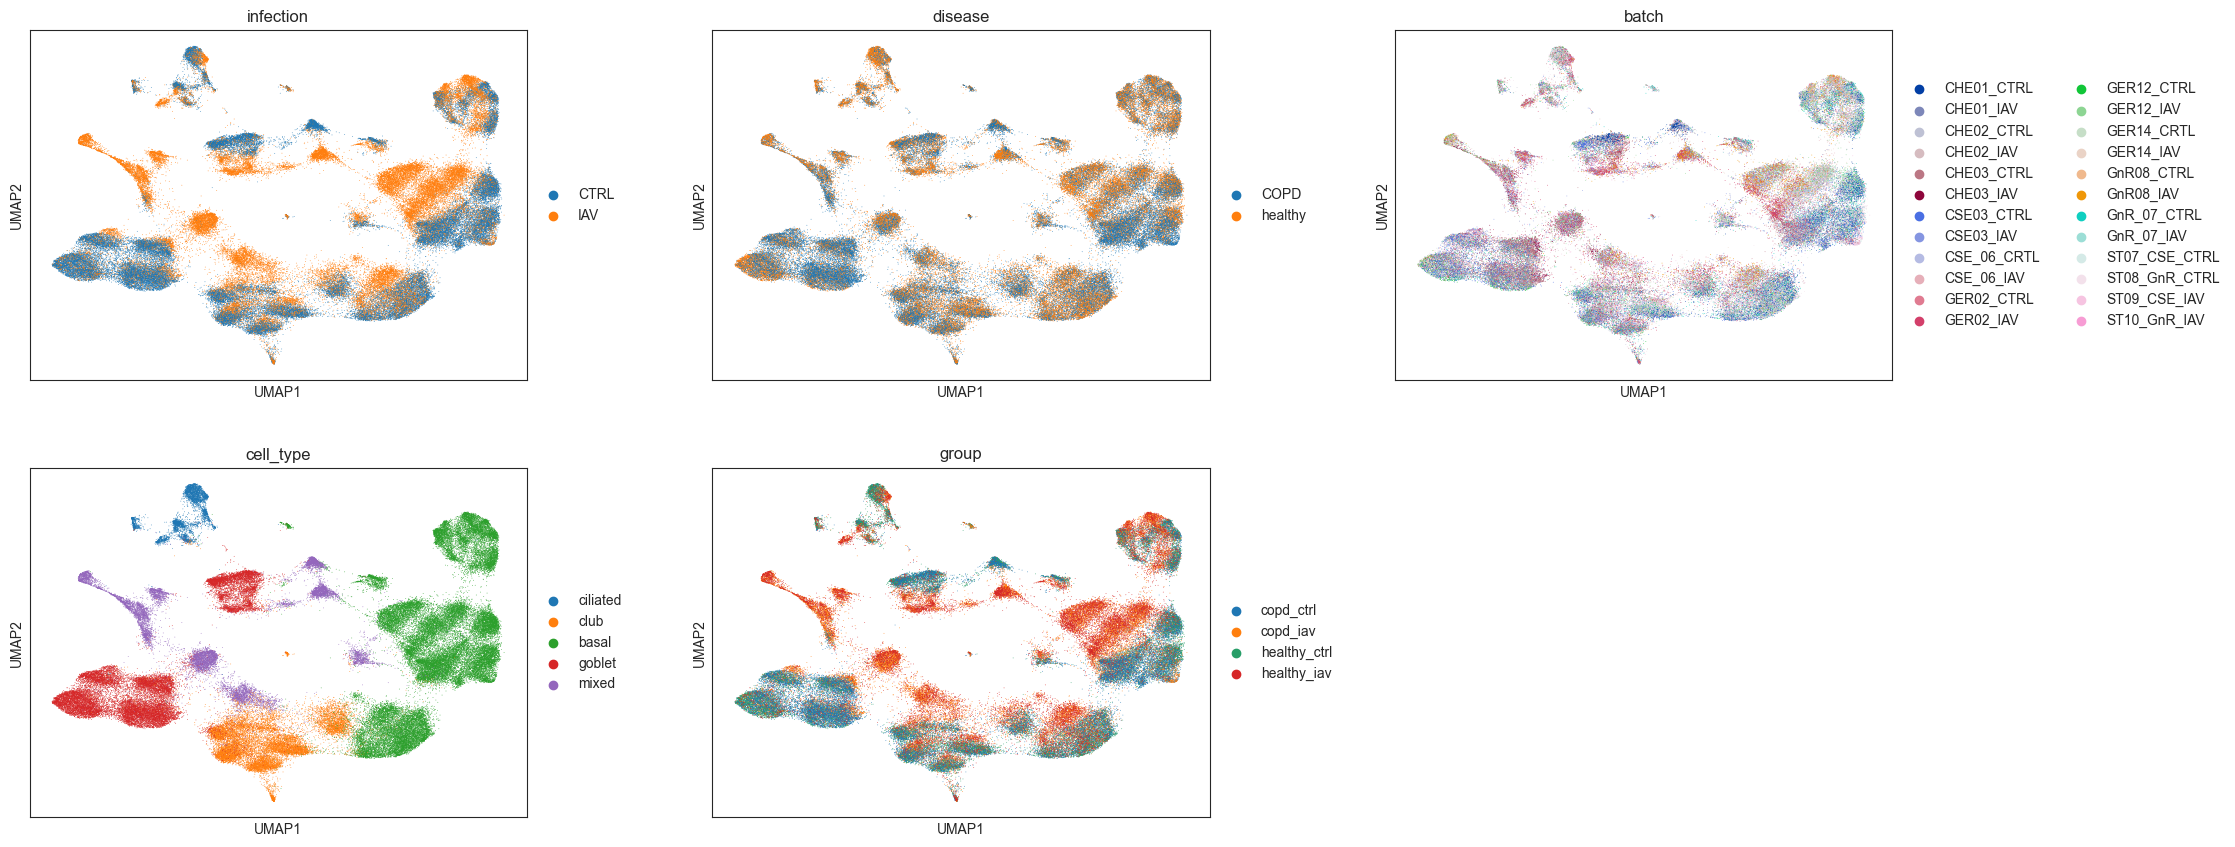

In [5]:
sc.pl.umap(adata, color=["infection", "disease", "batch", "cell_type", "group"], ncols=3, wspace=0.25)

### Batch correction

In the single cell best practices tutorial there should be a batch correction step next. Skipped because batch correction already took place.

In [6]:
sc.pp.neighbors(adata, use_rep='X_scANVI')

In [7]:
milo.make_nhoods(mdata, prop=0.1)

## Defining of Neighbourhoods

Text(0, 0.5, '# neighbouthoods')

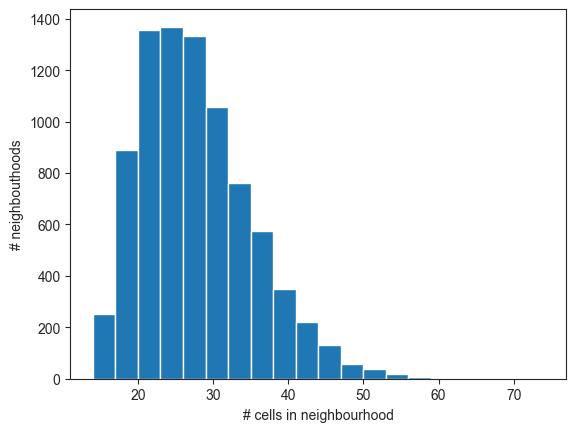

In [8]:
nhood_size = adata.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

In [9]:
np.median(nhood_size)

26.0

In [10]:
sc.pp.neighbors(adata, n_neighbors=50, use_rep="X_scANVI", key_added="milo")
milo.make_nhoods(mdata, neighbors_key="milo", prop=0.1)

Text(0, 0.5, '# neighbouthoods')

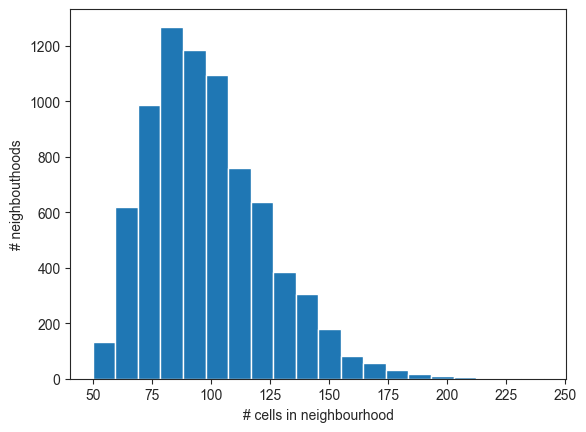

In [11]:
nhood_size = adata.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

In [12]:
np.median(nhood_size)

95.0

In [13]:
milo.count_nhoods(mdata, sample_col="batch")

MuData object with n_obs × n_vars = 97573 × 27208
  2 modalities
    rna:	97573 x 27208
      obs:	'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'viral_counts', 'infected_status', 'seed_labels', 'batch-scANVI', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'mt', 'ribo'
      uns:	'cell_compartment_colors', 'cell_states_colors', 'disease_colors', 'group_colors', 'infection_colors', 'batch_colors', 'cell_type_colors', 'neighbors', 'nhood_neighbors_key', 'milo'
      obsm:	'X_scANVI', 'X_umap', 'nhoods'
      obsp:	'distances', 'connectivities', 'milo_distances', 'milo_connectivities'
    milo:	24 x 7746
      var:	'index_cell', 'kth_distance'
      uns:	'sample_col'

Text(0, 0.5, 'Mean # cells per sample in nhood')

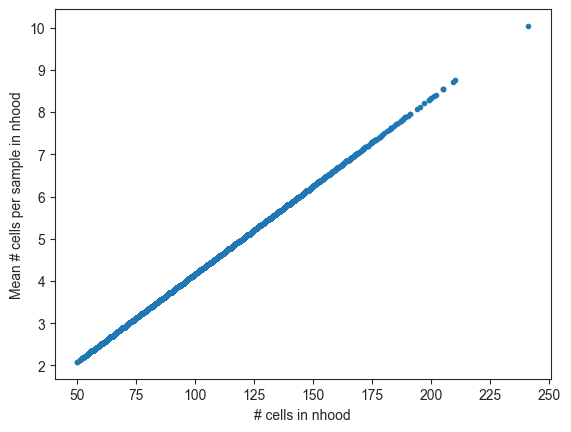

In [14]:
mean_n_cells = mdata["milo"].X.toarray().mean(0)
plt.plot(nhood_size, mean_n_cells, ".")
plt.xlabel("# cells in nhood")
plt.ylabel("Mean # cells per sample in nhood")

In [15]:
print({key: set(adata.obs[key]) for key in ['group', 'infection', 'disease']})

{'group': {'healthy_ctrl', 'healthy_iav', 'copd_ctrl', 'copd_iav'}, 'infection': {'IAV', 'CTRL'}, 'disease': {'COPD', 'healthy'}}


In [117]:
design = 'disease' # must be a column in adata.obs
model_contrasts = ('COPD', 'healthy')
model_contrasts = f'{design}{model_contrasts[0]}-{design}{model_contrasts[1]}'
design = f'~{design}'
milo.da_nhoods(
    mdata, design=design, model_contrasts=model_contrasts
)

## Data Diagnostics

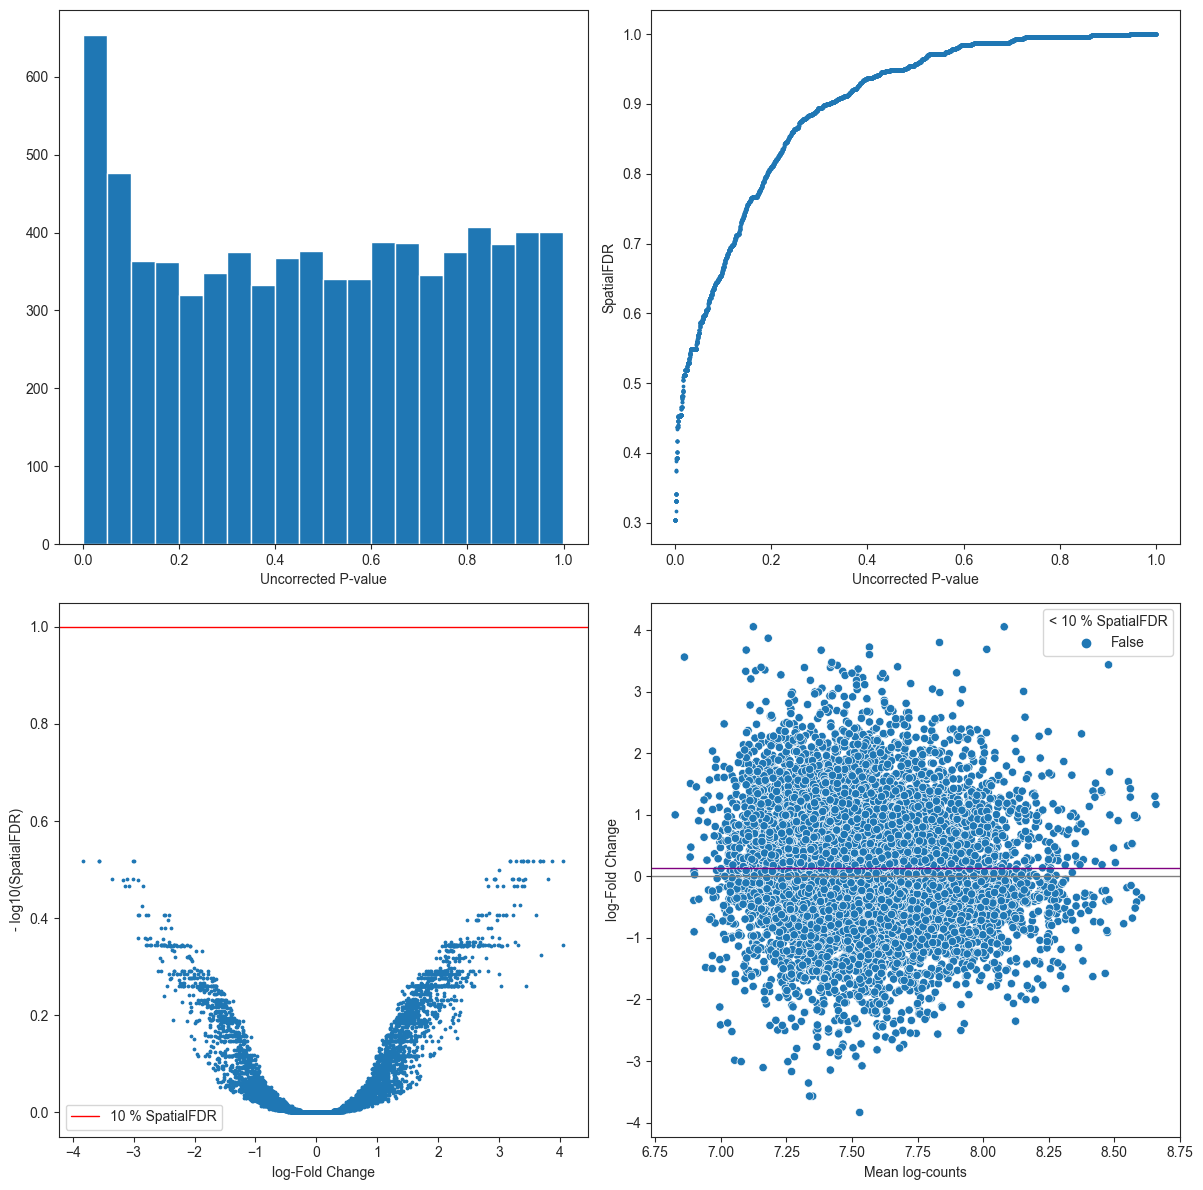

In [118]:
def plot_milo_diagnostics(mdata):
    alpha = 0.1  ## significance threshold

    with matplotlib.rc_context({"figure.figsize": [12, 12]}):

        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(mdata["milo"].var["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(
            mdata["milo"].var["PValue"],
            mdata["milo"].var["SpatialFDR"],
            s=3,
        )
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            mdata["milo"].var["logFC"],
            -np.log10(mdata["milo"].var["SpatialFDR"]),
            s=3,
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = mdata["milo"].var
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()


plot_milo_diagnostics(mdata)

## Plotting of log fold change in cell compartments

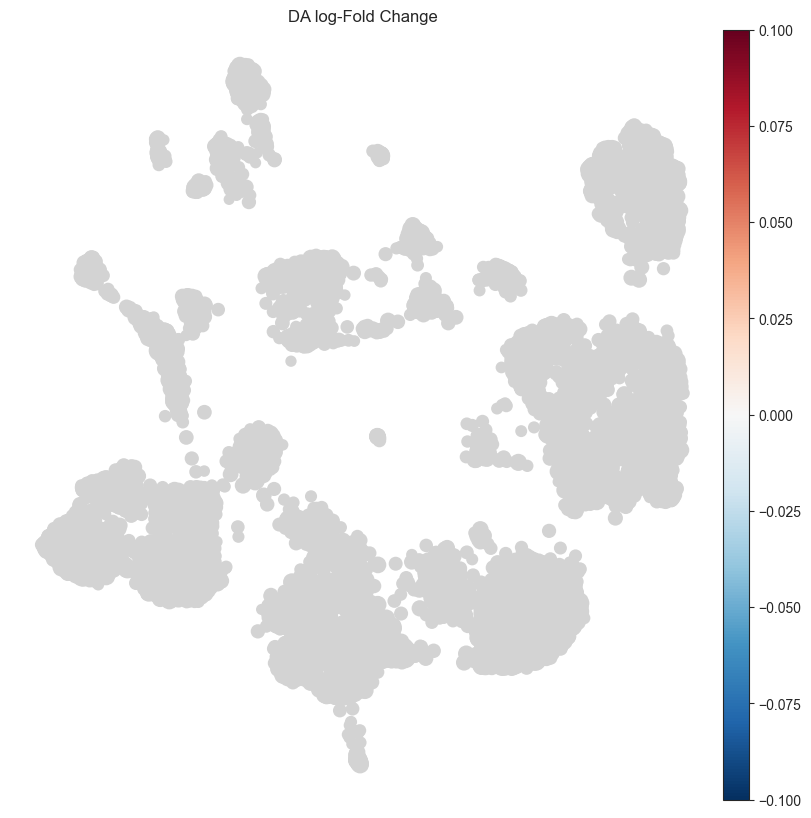

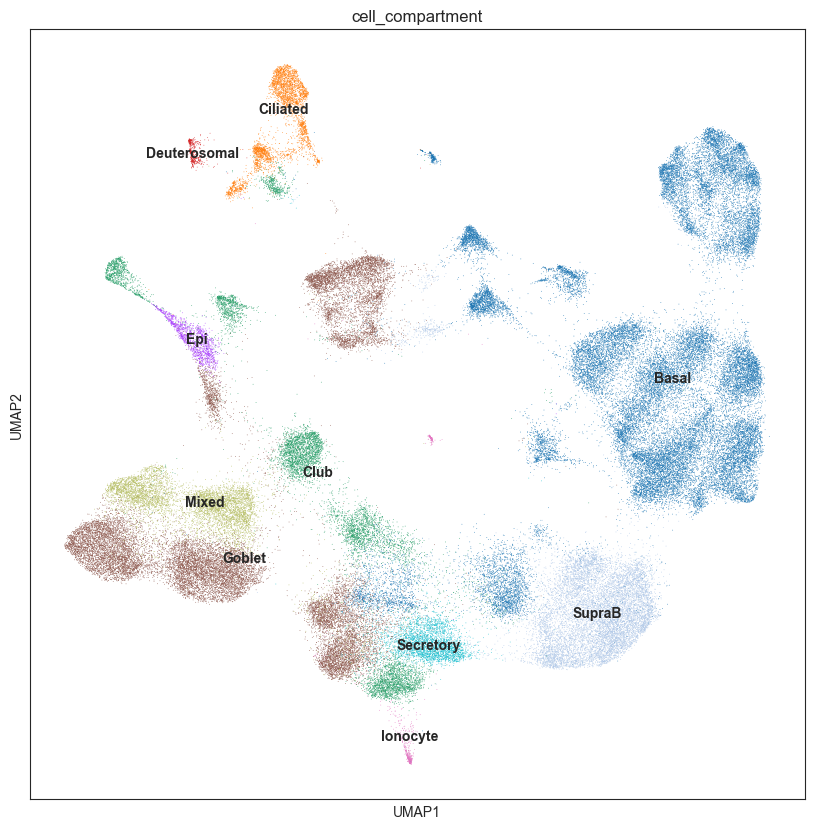

In [119]:
milo.build_nhood_graph(mdata)
with matplotlib.rc_context({"figure.figsize": [10, 10]}):
    pt.pl.milo.nhood_graph(mdata, alpha=0.1, min_size=5, plot_edges=False)
    sc.pl.umap(mdata["rna"], color="cell_compartment", legend_loc="on data")

In [120]:
milo.annotate_nhoods(mdata, anno_col="cell_compartment")
mdata['milo'].var['nhood_annotation'].value_counts()

nhood_annotation
Basal           3171
Goblet          1774
SupraB           871
Club             717
Mixed            505
Ciliated         276
Secretory        248
Epi              107
Ionocyte          41
Deuterosomal      36
Name: count, dtype: int64

In [121]:
threshold = 0.75  
mdata["milo"].var['nhood_annotation'] = mdata["milo"].var.apply(
    lambda row: 'Mixed' if row['nhood_annotation_frac'] < threshold else row['nhood_annotation'],
    axis=1
)
mdata['milo'].var['nhood_annotation'].value_counts()

nhood_annotation
Basal           3033
Goblet          1608
Mixed           1031
SupraB           814
Club             622
Ciliated         266
Secretory        206
Epi               93
Ionocyte          39
Deuterosomal      34
Name: count, dtype: int64

In [122]:
palette={
    'Basal': '#a6cee3',
    'Goblet': '#1f78b4',
    'SupraB': '#b2df8a',
    'Ciliated': '#33a02c',
    'Mixed': '#fb9a99',
    'Secretory': '#e31a1c',
    'Club': '#fdbf6f',
    'Deuterosomal': '#ff7f00',
    'Ionocyte': '#cab2d6',
    'Epi': '#6a3d9a',
}

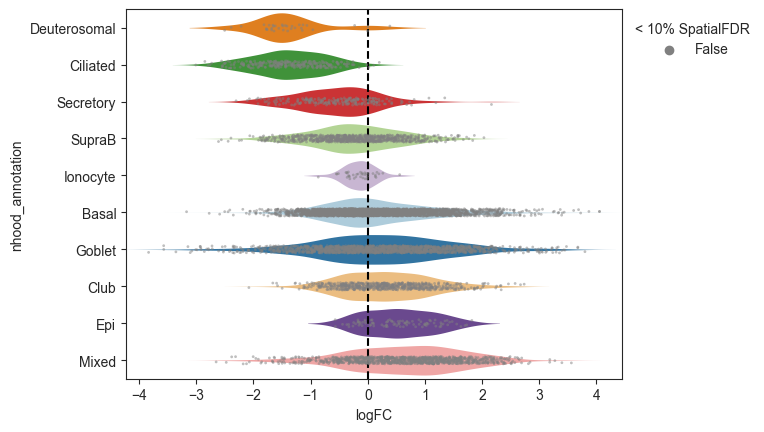

In [123]:
pt.pl.milo.da_beeswarm(
    mdata,
    palette=palette,
)
plt.show()

Text(0.5, 1.0, 'SupraB')

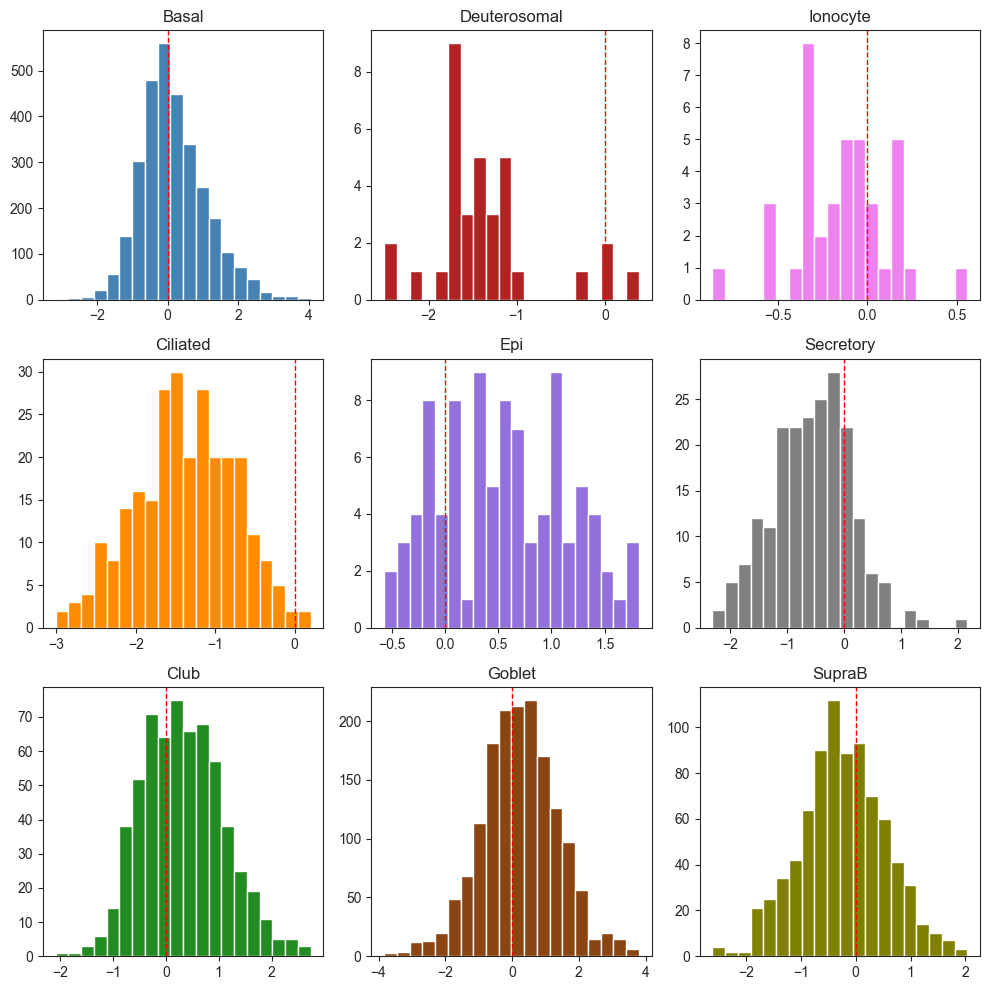

In [124]:
fig, axs = plt.subplots(3,3, sharey=False, sharex=False, tight_layout=False, figsize=(10,10))

# We can set the number of bins with the *bins* keyword argument.
axs[0,0].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["Basal"])]["logFC"], bins=20, color="steelblue")
axs[0,0].axvline(x=0, color='r', linewidth=1, linestyle='--')
axs[1,0].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["Ciliated"])]["logFC"], bins=20, color="darkorange")
axs[1,0].axvline(x=0, color='r', linewidth=1, linestyle='--')
axs[2,0].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["Club"])]["logFC"], bins=20, color="forestgreen")
axs[2,0].axvline(x=0, color='r', linewidth=1, linestyle='--')
axs[0,1].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["Deuterosomal"])]["logFC"], bins=20, color="firebrick")
axs[0,1].axvline(x=0, color='r', linewidth=1, linestyle='--')
axs[1,1].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["Epi"])]["logFC"], bins=20, color="mediumpurple")
axs[1,1].axvline(x=0, color='r', linewidth=1, linestyle='--')
axs[2,1].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["Goblet"])]["logFC"], bins=20, color="saddlebrown")
axs[2,1].axvline(x=0, color='r', linewidth=1, linestyle='--')
axs[0,2].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["Ionocyte"])]["logFC"], bins=20, color="violet")
axs[0,2].axvline(x=0, color='r', linewidth=1, linestyle='--')
axs[1,2].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["Secretory"])]["logFC"], bins=20, color="grey")
axs[1,2].axvline(x=0, color='r', linewidth=1, linestyle='--')
axs[2,2].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin(["SupraB"])]["logFC"], bins=20, color="olive")
axs[2,2].axvline(x=0, color='r', linewidth=1, linestyle='--')

axs[0,0].set_title("Basal")
axs[1,0].set_title("Ciliated")
axs[2,0].set_title("Club")
axs[0,1].set_title("Deuterosomal")
axs[1,1].set_title("Epi")
axs[2,1].set_title("Goblet")
axs[0,2].set_title("Ionocyte")
axs[1,2].set_title("Secretory")
axs[2,2].set_title("SupraB")

In [125]:
def significance_ratios(mdata_object):
    d = {"cell_compartments": [], "significance_ratio": []}
    for i in mdata_object["milo"].var["nhood_annotation"].unique():
        significant = 0
        insignificant = 0
        d["cell_compartments"].append(i)
        for j in mdata_object["milo"].var[mdata_object["milo"].var["nhood_annotation"].isin([i])]["Sig"]:
            if j == True:
                significant += 1
            else:
                insignificant += 1
        d["significance_ratio"].append(significant/(significant+insignificant))
    df = pd.DataFrame.from_dict(data=d)
    return df

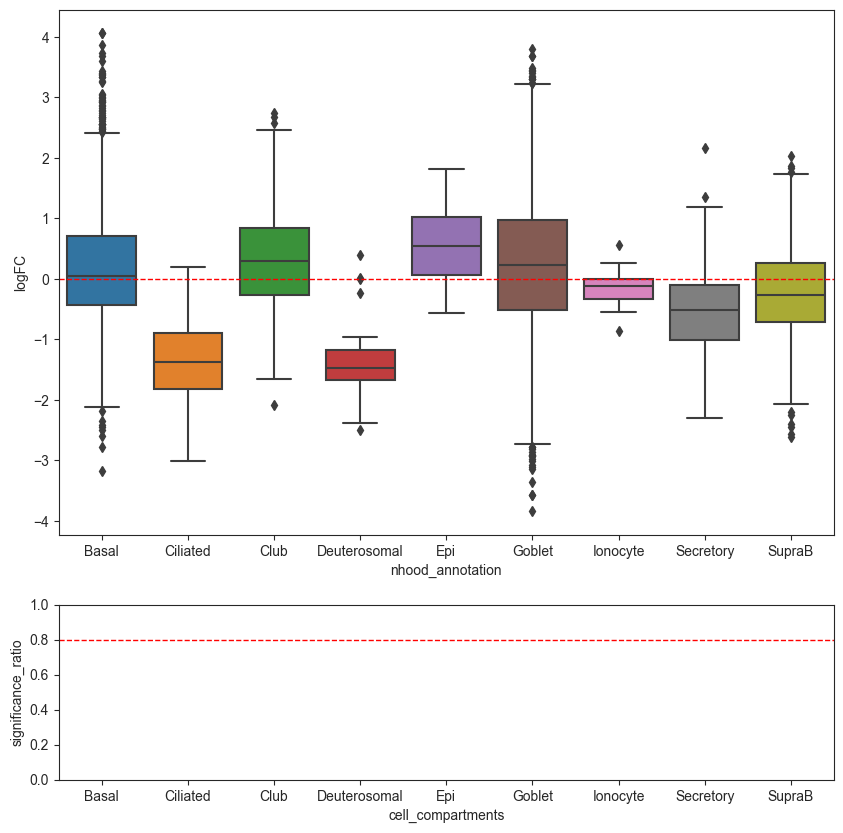

In [126]:
significance = significance_ratios(mdata)
order = ["Basal", "Ciliated", "Club", "Deuterosomal", "Epi", "Goblet", "Ionocyte", "Secretory", "SupraB"]
fig, axs = plt.subplots(2, figsize=(10,10), gridspec_kw={'height_ratios': [3, 1]})
sns.boxplot(data=mdata["milo"].var, x="nhood_annotation", y="logFC", order=order, ax=axs[0])
axs[0].axhline(y=0, color='r', linewidth=1, linestyle='--')
sns.barplot(data=significance, x="cell_compartments", y="significance_ratio", order=order, ax=axs[1], palette=palette)
plt.ylim(0, 1)
axs[1].axhline(y=0.8, color='r', linewidth=1, linestyle='--')

<Axes: xlabel='nhood_annotation', ylabel='logFC'>

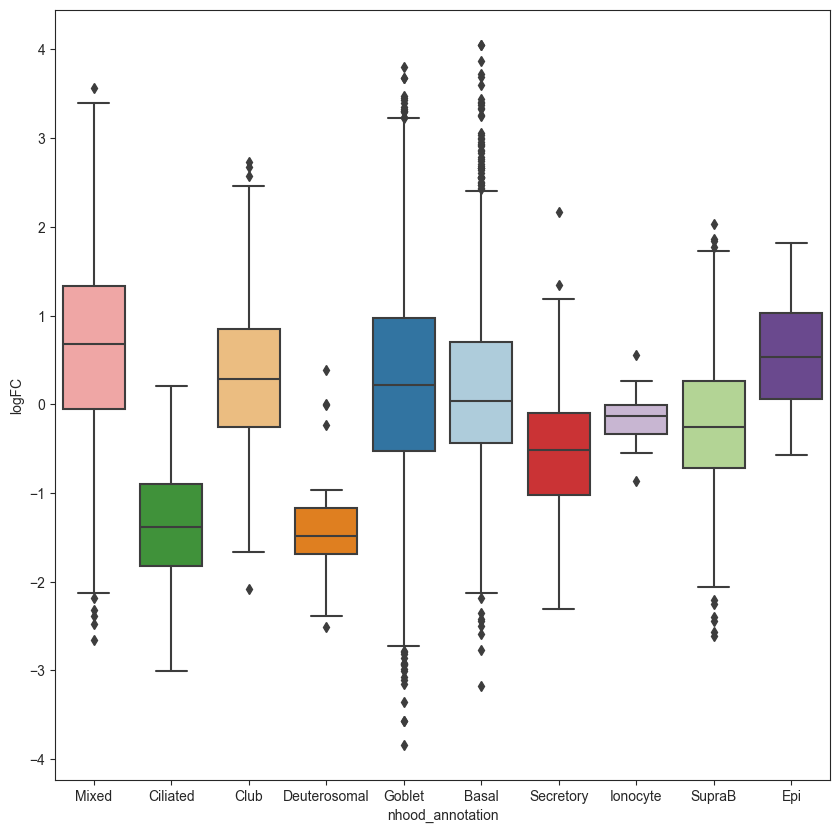

In [127]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=mdata["milo"].var, x="nhood_annotation", y="logFC", palette=palette)